In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/DATA CHẤT LƯỢNG KHÔNG KHÍ/data của viện nhi/data_output (1).xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/DATA CHẤT LƯỢNG KHÔNG KHÍ/data của viện nhi/pneumonia_01july2024 (2).xlsx')

df = pd.concat([df1, df2], axis=1)

df.head()

#

,date,holiday,thang,nam,dow,weekend,hn_dmo3a,hn_dmo3m,hn_dmno,hn_dmno2,...,hn_dmco,hn_dmpm10,hn_dmpm25,hn_dmpm1,hn_dmwisp,hn_dmso2,hn_dmtemp,hn_dmhum,date,count
0,2010-01-01,1,1,2010,5,0,12.773337,19.155500,73.313637,37.073391,...,2869.264160,82.683708,63.687817,53.553741,0.935593,22.951050,16.750,96.25,2010-01-01,13
1,2010-01-02,0,1,2010,6,1,11.941775,21.280800,79.978386,37.754845,...,3091.271973,53.249500,37.463985,30.909113,1.031725,21.106625,16.725,93.50,2010-01-02,24
2,2010-01-03,0,1,2010,0,1,54.091862,66.220001,51.733109,52.447487,...,2647.305420,98.332199,56.999287,44.949402,1.011433,28.034859,18.625,83.50,2010-01-03,19
3,2010-01-04,0,1,2010,1,0,39.317726,60.505001,52.855743,60.220432,...,2787.883301,76.243179,50.712963,41.189350,1.534541,20.061163,19.825,87.25,2010-01-04,15
4,2010-01-05,0,1,2010,2,0,52.317215,74.869003,46.449150,50.686054,...,2615.624268,48.950001,33.689999,28.730000,1.638597,10.465546,22.025,86.00,2010-01-05,17


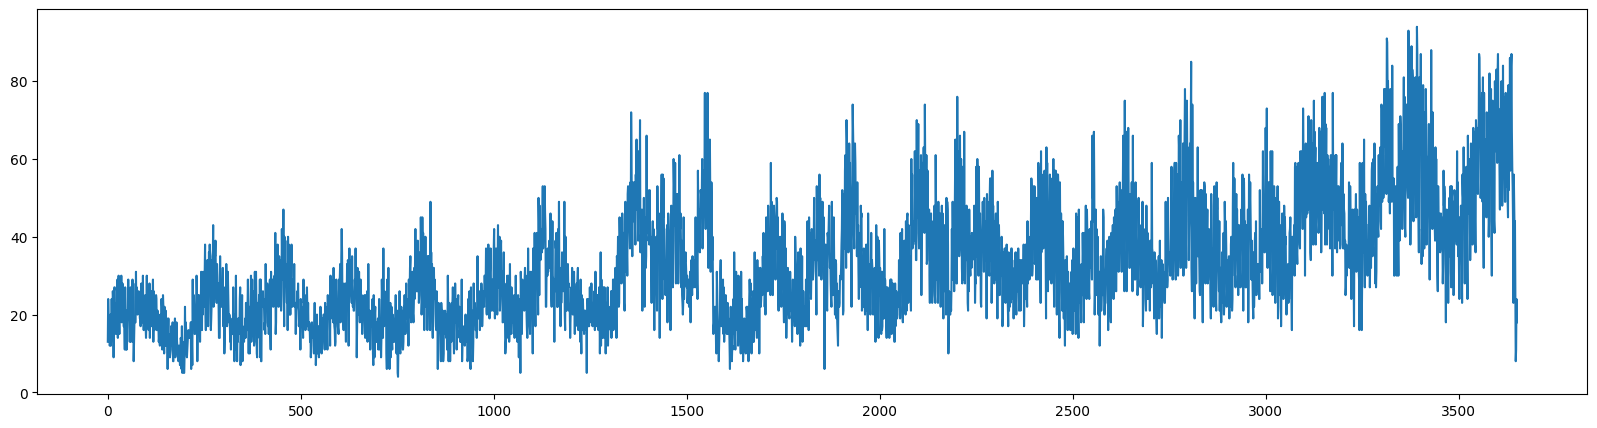

In [ ]:
count = df['count']


count.plot(figsize=(20, 5))
plt.show()


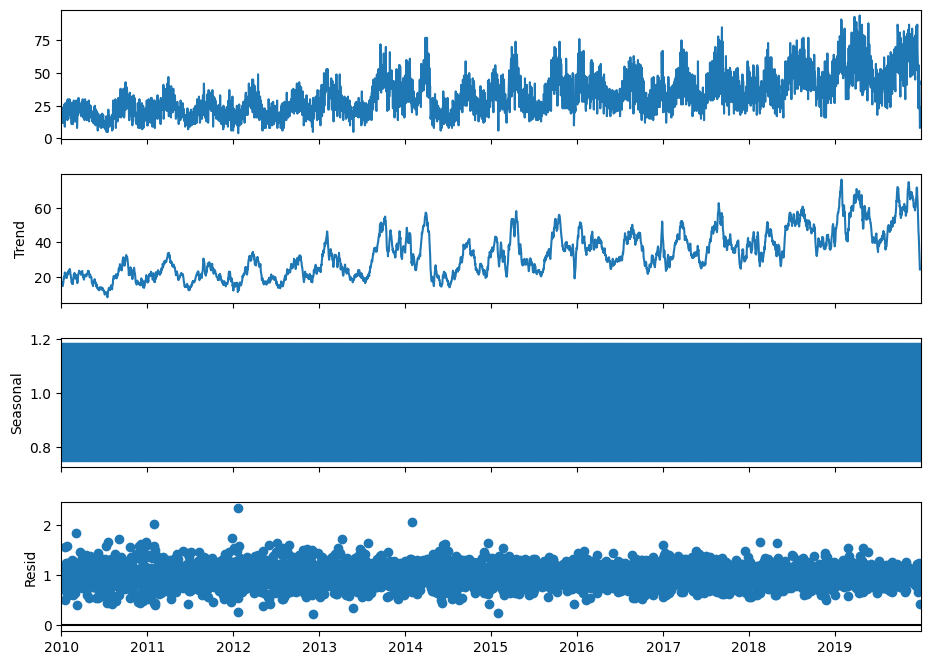

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_season = pd.read_excel('/content/drive/MyDrive/DATA CHẤT LƯỢNG KHÔNG KHÍ/data của viện nhi/pneumonia_01july2024 (2).xlsx', parse_dates=['date'], index_col='date')

result = seasonal_decompose(df_season, model='multiplicative')
fig = result.plot()
fig.set_size_inches(10, 7)

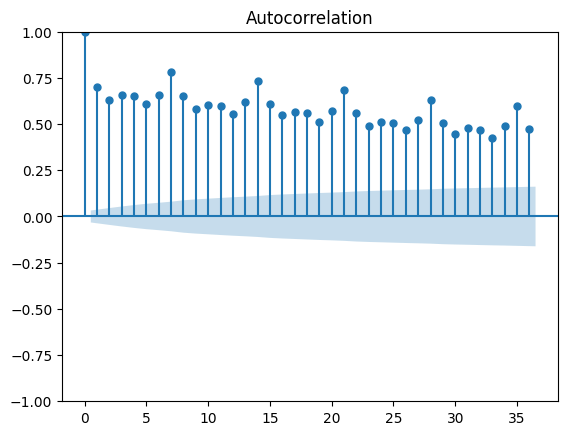

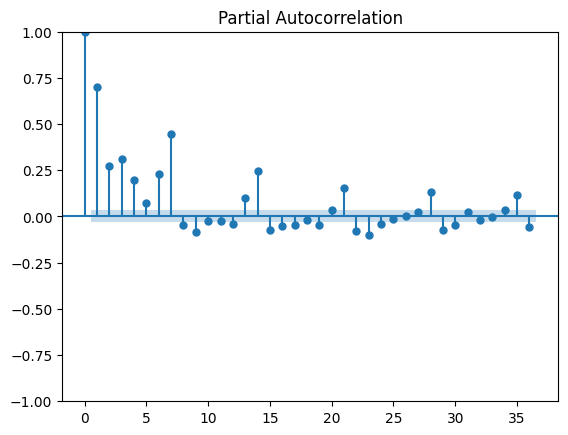

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Vẽ đồ thị ACF và PACF để chọn tham số cho SARIMA
plot_acf(count)
plot_pacf(count)
plt.show()

In [ ]:
colums = ['count','hn_dmo3a','hn_dmno']
data_arima = df[colums]
data_arima.head()


train_size = int(0.9 * len(data_arima))
train_data = data_arima[:train_size]
x_train = train_data.drop('count', axis=1)
y_train = train_data['count']


test_data = data_arima[train_size:]
x_test = test_data.drop('count', axis=1)
y_test = test_data['count']


In [ ]:
!pip install pmdarima

In [ ]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

In [ ]:
! pip install optuna

In [ ]:
import optuna

def objective(trial):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)
    P = trial.suggest_int('P', 0, 5)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 5)
    s = trial.suggest_categorical('s', [11])

    try:
        model = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
        result = model.fit(disp=False)
        return result.aic
    except:
        return float("inf")

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(y_train, exog=x_train, order=(5, 1, 3), seasonal_order=(0, 0, 2, 11))

# Huấn luyện mô hình
model_fit = model.fit(disp=False)

# In kết quả tóm tắt của mô hình
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                   count   No. Observations:                 3286
Model:             SARIMAX(5, 1, 3)x(0, 0, [1, 2], 11)   Log Likelihood              -11553.088
Date:                                 Wed, 04 Dec 2024   AIC                          23132.176
Time:                                         16:28:48   BIC                          23211.438
Sample:                                              0   HQIC                         23160.555
                                                - 3286                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hn_dmo3a       0.0008      0.005      0.163      0.871      -0.009       0

In [ ]:
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=x_test)


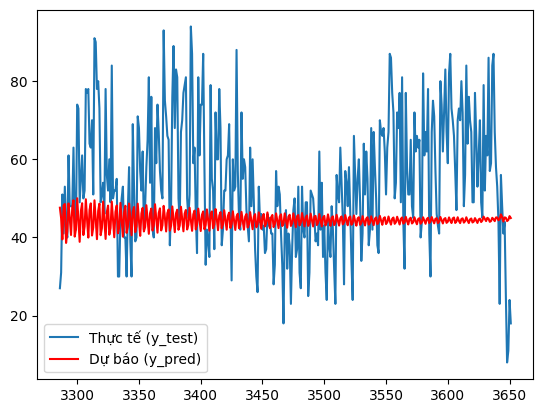

MAPE: 0.27715267147757966
RMSE: 18.850766201708378


In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

plt.plot(y_test, label='Thực tế (y_test)')
plt.plot(y_pred, label='Dự báo (y_pred)', color='red')
plt.legend()
plt.show()

# 6. Tính toán độ lỗi RMSE trên tập kiểm thử
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')